In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
!pip install nltk
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dense
from tensorflow.keras.models import Sequential


DATASETS IMPORTATION

In [33]:
df_1 = pd.read_parquet("train_nuevo.parquet")
df_2 = pd.read_parquet("test_nuevo.parquet")
mask_spanish_1=df_1["Language"]==3
mask_spanish_2=df_2["Language"]==3
dataset_1=df_1[mask_spanish_1]
dataset_2=df_2[mask_spanish_2]

In [34]:
dataset = pd.concat([dataset_1, dataset_2])
len(dataset)

26622

# EDA

In [35]:
#Lower case all
dataset = dataset.applymap(lambda x: x.lower() if isinstance(x, str) else x)
dataset.columns = map(str.lower, dataset.columns)

<ipython-input-35-4d0ff5863734>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dataset = dataset.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [36]:
dataset=dataset.drop_duplicates(subset=["question"])

In [37]:
len(dataset)

24211

In [38]:
nltk.download('stopwords')
stops = set(stopwords.words('spanish'))
dataset["question"] = dataset['question'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
def clean_html(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text()

dataset['question'] = dataset['question'].apply(clean_html)

In [40]:
def clean_text(text):
  text = re.sub(r'[^\w\s]', '', text)
  text = text.lower()
  stop_words = set(stopwords.words('english'))
  text = ' '.join([word for word in text.split() if word not in stop_words])

  return text

dataset['question'] = dataset['question'].apply(clean_text)

In [41]:
def clean_text_v1(text):
    text = BeautifulSoup(text, "lxml").get_text()
    text = text.replace('\n', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    return text
dataset['question'] = dataset['question'].apply(clean_text_v1)

In [42]:
topic_counts = dataset['topic1'].value_counts()
filtered_topics = topic_counts[topic_counts > 1000]
num_topics = len(filtered_topics)
print(f"Number of topics with frequency over 500: {num_topics}")

Number of topics with frequency over 500: 6


In [43]:
#Frecuence division
category_counts = dataset["topic1"].value_counts()
mask_base=category_counts >= 100
mask_limit=category_counts <= 1000
mask_combined=mask_base & mask_limit
categories = category_counts[mask_combined]
titles_list = categories.index.tolist()
dataset_final = dataset[dataset['topic1'].isin(titles_list)]
#dataset.to_csv('dataset_usp_filtered_final.csv', index=False)
print(len(dataset_final['topic1'].unique()))
print(len(dataset_final))

36
15368


In [44]:
dataset_excluded = dataset[~dataset['topic1'].isin(dataset_final['topic1'])]
len(dataset_excluded)

8843

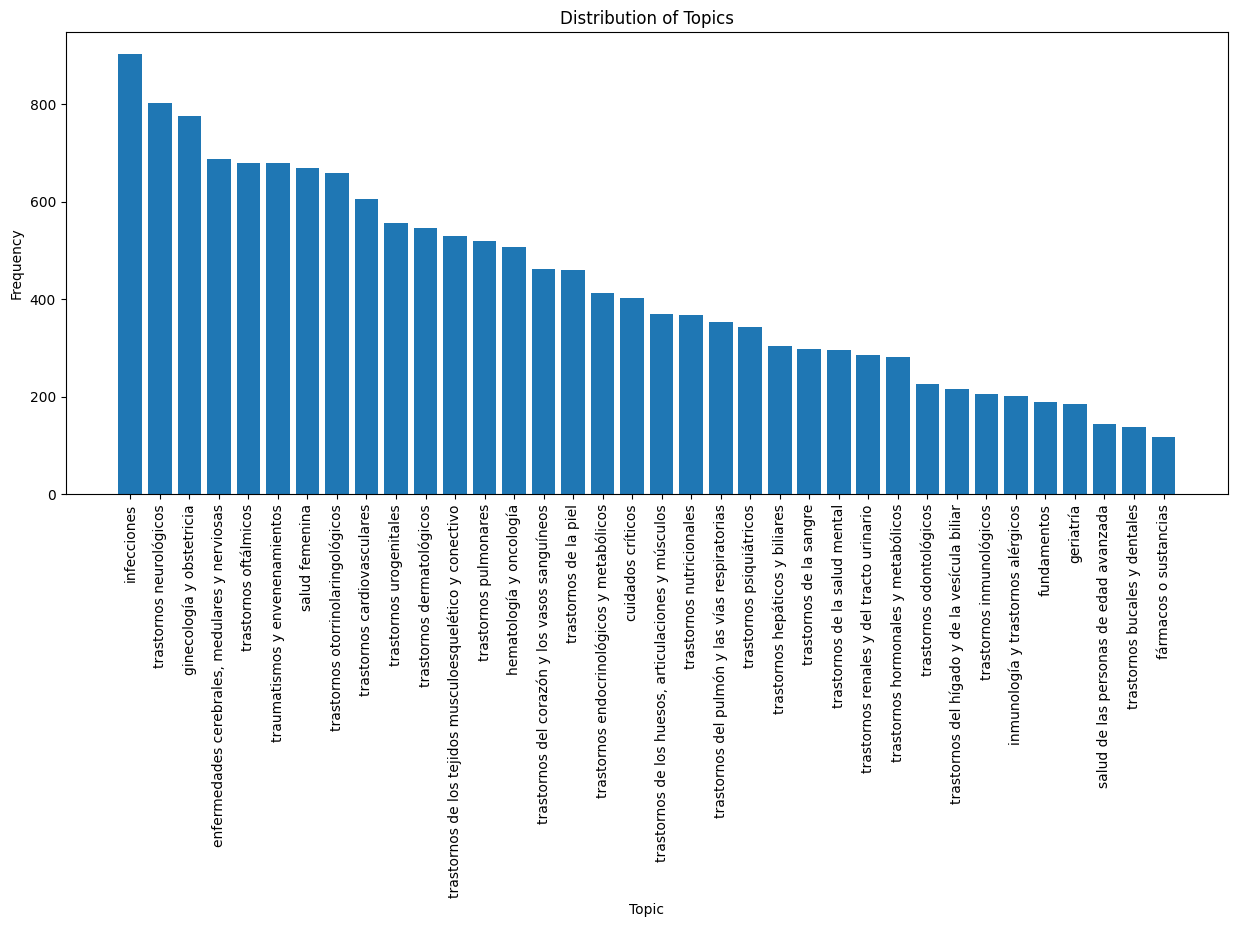

In [45]:
topic_counts = dataset_final['topic1'].value_counts()

plt.figure(figsize=(15, 6))
plt.bar(topic_counts.index, topic_counts.values)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Distribution of Topics')
plt.xticks(rotation=90)
plt.show()


In [46]:
dataset_final=dataset_final[["topic1", "question"]]
label = LabelEncoder()
dataset_final['category'] = label.fit_transform(dataset_final['topic1'])
dataset_final.head()

<ipython-input-46-f47f75559218>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_final['category'] = label.fit_transform(dataset_final['topic1'])


,topic1,question,category
11,trastornos psiquiátricos,cómo reconocen signos síntomas trastorno perso...,31
17,trastornos cardiovasculares,dame información muerte súbita origen cardíaco...,12
22,trastornos oftálmicos,cómo trata enrojecimiento ocular,29
30,salud femenina,cómo manejan enfermedades hígado vesícula bili...,10
31,trastornos del corazón y los vasos sanguíneos,cómo causan anginas pecho frecuentes,18


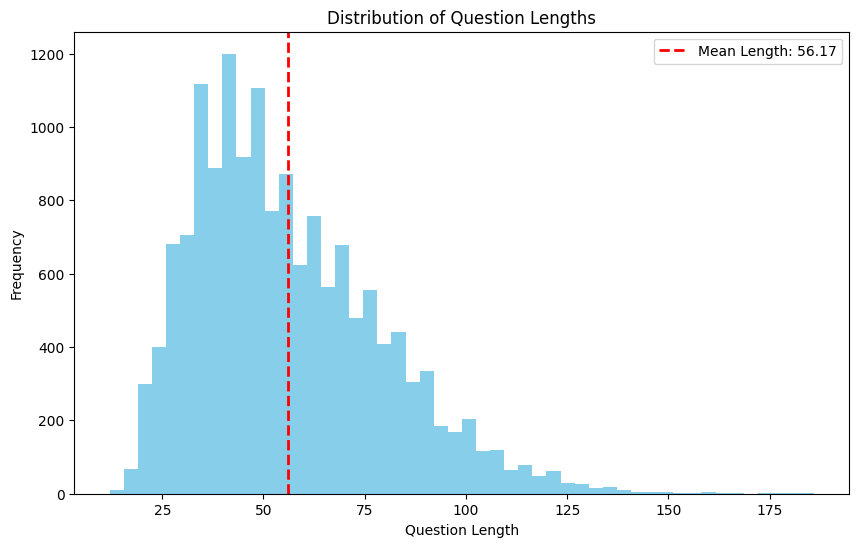

Mean length: 56.17250130140552
Max length: 186
Min length: 12


In [17]:
question_lengths = dataset_final["question"].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(question_lengths, bins=50, color='skyblue')
plt.xlabel('Question Length')
plt.ylabel('Frequency')
plt.title('Distribution of Question Lengths')

mean_length = question_lengths.mean()
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=2, label=f'Mean Length: {mean_length:.2f}')
plt.legend()

plt.show()

mean_length = question_lengths.mean()
max_length = question_lengths.max()
min_length = question_lengths.min()

print(f"Mean length: {mean_length}")
print(f"Max length: {max_length}")
print(f"Min length: {min_length}")

In [18]:
#save dataset
dataset_final.to_csv('dataset_usp_cleaned_final.csv', index=False)

In [19]:
unique_topics_df = dataset_final[['topic1', 'category']].drop_duplicates().reset_index(drop=True)
print(unique_topics_df)
unique_topics_df.to_csv('unique_topics.csv', index=False)

                                               topic1  category
0                            trastornos psiquiátricos        31
1                         trastornos cardiovasculares        12
2                               trastornos oftálmicos        29
3                                      salud femenina        10
4       trastornos del corazón y los vasos sanguíneos        18
5                           trastornos dermatológicos        21
6                             trastornos de la sangre        15
7                   trastornos otorrinolaringológicos        30
8                                   cuidados críticos         0
9                               trastornos de la piel        13
10                                        infecciones         7
11     enfermedades cerebrales, medulares y nerviosas         1
12                trastornos hormonales y metabólicos        24
13                      trastornos de la salud mental        14
14                                      

# TRAIN-TEST

In [22]:
dataset = pd.read_csv("dataset_usp_cleaned_final.csv")

In [23]:
print(len(dataset['topic1'].unique()))
print(len(dataset))

36
15368


In [24]:
X_train, X_test, y_train, y_test = train_test_split (dataset["question"], dataset['category'], shuffle=True, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12294,), (3074,), (12294,), (3074,))

In [ ]:
nltk.download('stopwords')
vectorizer = TfidfVectorizer(stop_words=nltk.corpus.stopwords.words('spanish'))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


((12294, 5347), (3074, 5347), (12294,), (3074,))

# Machine Learning Models: SVM



In [ ]:

supportvectormachine = SVC(kernel='linear')
supportvectormachine.fit(X_train, y_train)
y_pred = supportvectormachine.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        85
           1       0.70      0.78      0.74       138
           2       0.98      0.93      0.95        44
           3       0.79      1.00      0.88        23
           4       0.94      0.94      0.94        31
           5       0.87      0.85      0.86       169
           6       0.84      0.87      0.85       100
           7       0.92      0.97      0.94       185
           8       0.85      0.71      0.77        41
           9       0.89      0.86      0.87        28
          10       0.82      0.78      0.80       126
          11       0.92      0.85      0.88        26
          12       0.85      0.88      0.86       132
          13       0.72      0.70      0.71        86
          14       0.84      0.66      0.74        62
          15       0.74      0.77      0.75        52
          16       0.82      0.64      0.72        70
          17       0.80    

In [ ]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 0.8518782071467672
Recall: 0.8487312947299935


In [ ]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.8482376726188199


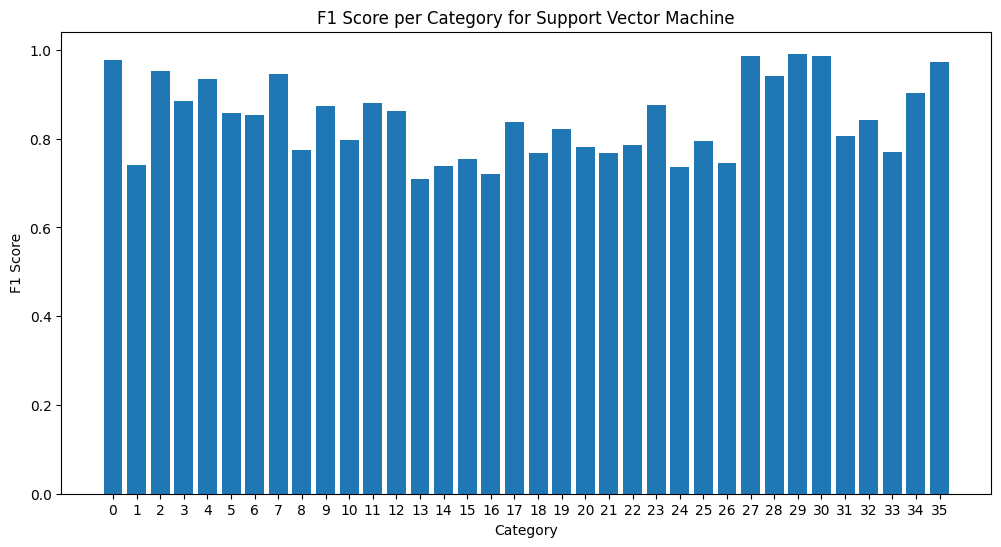

In [ ]:
f1_scores_per_category = f1_score(y_test, y_pred, average=None)

plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores_per_category)), f1_scores_per_category)
plt.xlabel("Category")
plt.ylabel("F1 Score")
plt.title("F1 Score per Category for Support Vector Machine")
plt.xticks(range(len(f1_scores_per_category)))
plt.show()


# Machine Learning Models: Naive Bayes



              precision    recall  f1-score   support

           0       0.92      0.95      0.94        85
           1       0.63      0.65      0.64       138
           2       1.00      0.66      0.79        44
           3       1.00      0.61      0.76        23
           4       1.00      0.74      0.85        31
           5       0.77      0.87      0.82       169
           6       0.76      0.90      0.83       100
           7       0.60      0.99      0.75       185
           8       0.91      0.49      0.63        41
           9       0.92      0.86      0.89        28
          10       0.75      0.78      0.76       126
          11       1.00      0.42      0.59        26
          12       0.61      0.88      0.72       132
          13       0.71      0.45      0.55        86
          14       0.89      0.39      0.54        62
          15       0.95      0.35      0.51        52
          16       0.94      0.41      0.57        70
          17       0.71    

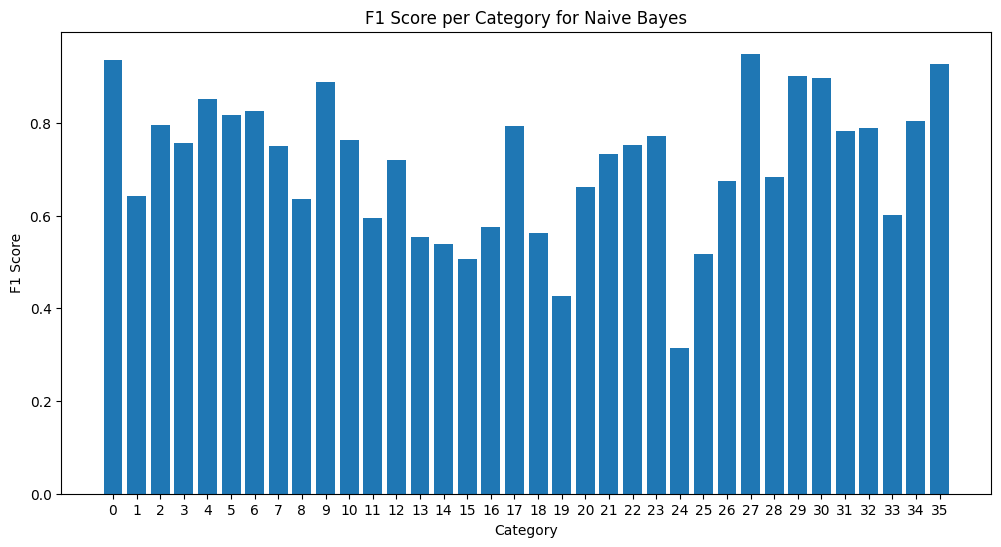

In [ ]:
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

# Calculate F1 score for each category
f1_scores_per_category = f1_score(y_test, y_pred, average=None)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores_per_category)), f1_scores_per_category)
plt.xlabel("Category")
plt.ylabel("F1 Score")
plt.title("F1 Score per Category for Naive Bayes")
plt.xticks(range(len(f1_scores_per_category)))  # Display x-axis ticks for each category
plt.show()


# Machine Learning Models: KNN



Best parameters: {'n_neighbors': 3}
Best F1 score: 0.7549575679142386
              precision    recall  f1-score   support

           0       0.95      0.94      0.95        85
           1       0.64      0.73      0.68       138
           2       0.87      0.91      0.89        44
           3       0.96      0.96      0.96        23
           4       0.93      0.81      0.86        31
           5       0.76      0.84      0.80       169
           6       0.70      0.81      0.75       100
           7       0.94      0.92      0.93       185
           8       0.68      0.78      0.73        41
           9       0.80      0.86      0.83        28
          10       0.75      0.74      0.74       126
          11       0.74      0.77      0.75        26
          12       0.79      0.75      0.77       132
          13       0.52      0.65      0.58        86
          14       0.67      0.74      0.70        62
          15       0.58      0.60      0.59        52
          1

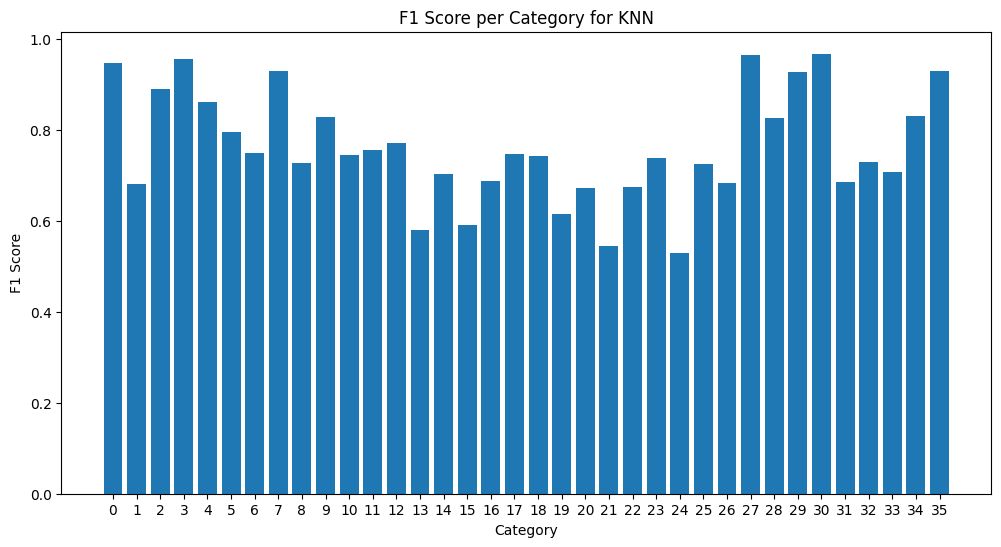

In [ ]:
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}


knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score:", grid_search.best_score_)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

f1_scores_per_category = f1_score(y_test, y_pred, average=None)

plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores_per_category)), f1_scores_per_category)
plt.xlabel("Category")
plt.ylabel("F1 Score")
plt.title("F1 Score per Category for KNN")
plt.xticks(range(len(f1_scores_per_category)))
plt.show()


# MACHINE LEARNING MODEL: XGBOOST

In [ ]:
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9]
}

model = XGBClassifier()
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3, scoring='f1_weighted', n_jobs=-1)
random_search.fit(X_train, y_train)

print(random_search.best_params_)

{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}


              precision    recall  f1-score   support

           0       0.95      0.87      0.91        85
           1       0.56      0.64      0.59       138
           2       0.90      0.84      0.87        44
           3       0.87      0.87      0.87        23
           4       0.90      0.84      0.87        31
           5       0.87      0.69      0.77       169
           6       0.76      0.72      0.74       100
           7       0.67      0.92      0.78       185
           8       0.72      0.63      0.68        41
           9       0.89      0.86      0.87        28
          10       0.79      0.76      0.77       126
          11       0.95      0.69      0.80        26
          12       0.62      0.64      0.63       132
          13       0.53      0.63      0.58        86
          14       0.79      0.60      0.68        62
          15       0.67      0.54      0.60        52
          16       0.54      0.49      0.51        70
          17       0.69    

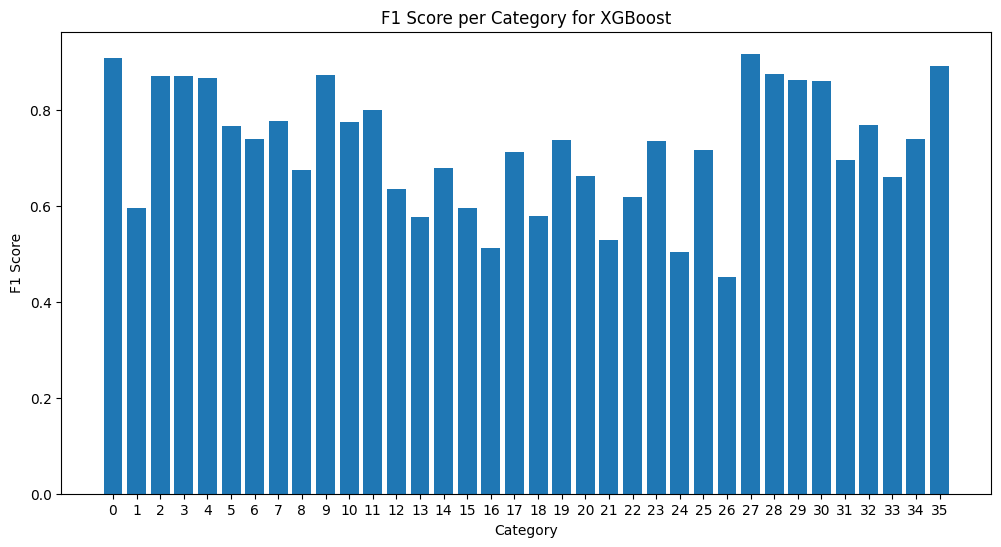

In [ ]:

xgb_model = XGBClassifier(subsample=0.8, n_estimators=100, max_depth=5, learning_rate=0.2)
xgb_model.fit(X_train, y_train)


y_pred = xgb_model.predict(X_test)


print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")


f1_scores_per_category = f1_score(y_test, y_pred, average=None)


plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores_per_category)), f1_scores_per_category)
plt.xlabel("Category")
plt.ylabel("F1 Score")
plt.title("F1 Score per Category for XGBoost")
plt.xticks(range(len(f1_scores_per_category)))
plt.show()

# DEEP LEARNING MODEL: LSTM

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 80s 393ms/step - accuracy: 0.1411 - loss: 3.2559
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 68s 324ms/step - accuracy: 0.7736 - loss: 0.9230
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 324ms/step - accuracy: 0.9046 - loss: 0.3264
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 63s 325ms/step - accuracy: 0.9276 - loss: 0.2180
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 83s 329ms/step - accuracy: 0.9349 - loss: 0.1753
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 80s 324ms/step - accuracy: 0.9435 - loss: 0.1438
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 62s 319ms/step - accuracy: 0.9502 - loss: 0.1238
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - accuracy: 0.9501 - loss: 0.1262
Epoch 9/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 83s 322ms/step - accuracy: 0.9579 - loss: 0.1055
Epoch 10/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 81s 321ms/step - accuracy: 0.9577 - loss: 0.0995
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8728 - loss: 0.4005
Test accuracy: 0.8623942732810974
9

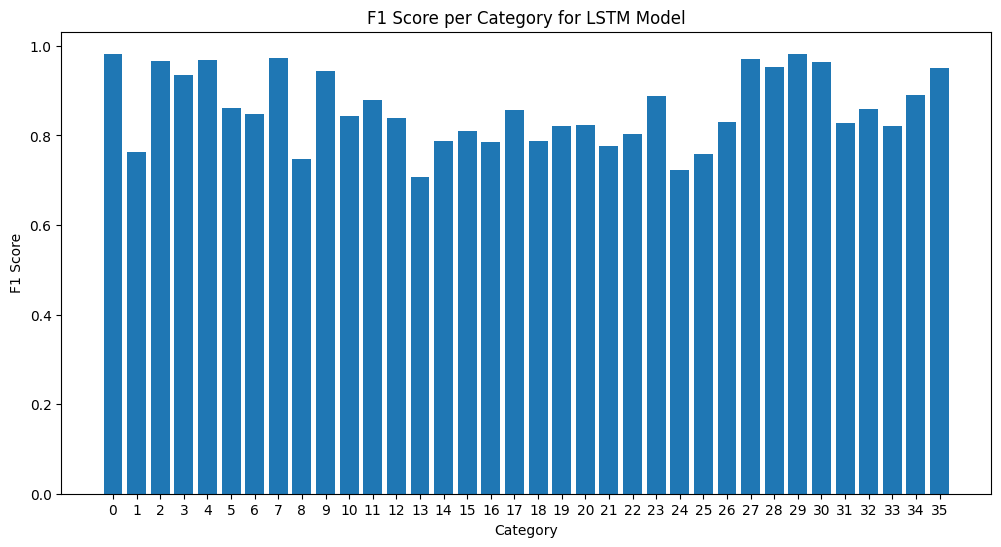

In [25]:
X_train, X_test, y_train, y_test = train_test_split (dataset["question"], dataset['category'], shuffle=True, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(dataset['question'])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


max_sequence_length = 186
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)


vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(100))
model_lstm.add(Dense(len(dataset['category'].unique()), activation='softmax'))


model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=64)


loss, accuracy = model_lstm.evaluate(X_test_pad, y_test)
print('Test accuracy:', accuracy)


y_pred_prob = model_lstm.predict(X_test_pad)
y_pred = y_pred_prob.argmax(axis=1)


print(classification_report(y_test, y_pred))


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")


f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")


f1_scores_per_category = f1_score(y_test, y_pred, average=None)


plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores_per_category)), f1_scores_per_category)
plt.xlabel("Category")
plt.ylabel("F1 Score")
plt.title("F1 Score per Category for LSTM Model")
plt.xticks(range(len(f1_scores_per_category)))
plt.show()


In [26]:

model_lstm.save('model_lstm.h5')


# DEEP LEARNING MODEL: CNN

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 207ms/step - accuracy: 0.1029 - loss: 3.3345
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step - accuracy: 0.6478 - loss: 1.3140
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - accuracy: 0.8719 - loss: 0.4308
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.9172 - loss: 0.2401
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 30s 154ms/step - accuracy: 0.9411 - loss: 0.1742
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 31s 160ms/step - accuracy: 0.9444 - loss: 0.1463
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.9506 - loss: 0.1207
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.9568 - loss: 0.1089
Epoch 9/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 31s 161ms/step - accuracy: 0.9624 - loss: 0.0951
Epoch 10/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.9663 - loss: 0.0842
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8568 - loss: 0.4701
Test accuracy: 0.8474300503730774
9

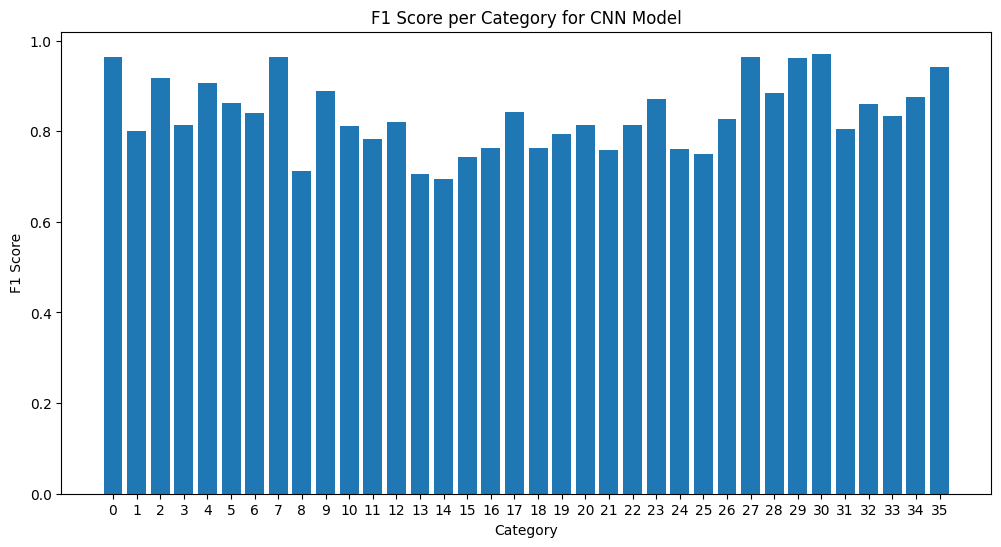

In [ ]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(len(dataset['category'].unique()), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(X_train_pad, y_train, epochs=10, batch_size=64)

loss, accuracy = model.evaluate(X_test_pad, y_test)
print('Test accuracy:', accuracy)



y_pred_prob = model.predict(X_test_pad)
y_pred = y_pred_prob.argmax(axis=1)


print(classification_report(y_test, y_pred))


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")


f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")


f1_scores_per_category = f1_score(y_test, y_pred, average=None)


plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores_per_category)), f1_scores_per_category)
plt.xlabel("Category")
plt.ylabel("F1 Score")
plt.title("F1 Score per Category for CNN Model")
plt.xticks(range(len(f1_scores_per_category)))
plt.show()

# DEEP LEARNING MODEL: LSTM+CNN


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


193/193 ━━━━━━━━━━━━━━━━━━━━ 79s 370ms/step - accuracy: 0.1272 - loss: 3.2579
Epoch 2/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 66s 338ms/step - accuracy: 0.7724 - loss: 0.8417
Epoch 3/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 81s 335ms/step - accuracy: 0.9105 - loss: 0.2912
Epoch 4/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 81s 329ms/step - accuracy: 0.9330 - loss: 0.1874
Epoch 5/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 331ms/step - accuracy: 0.9493 - loss: 0.1418
Epoch 6/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 82s 330ms/step - accuracy: 0.9574 - loss: 0.1180
Epoch 7/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 84s 341ms/step - accuracy: 0.9591 - loss: 0.1067
Epoch 8/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 81s 337ms/step - accuracy: 0.9674 - loss: 0.0909
Epoch 9/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 83s 340ms/step - accuracy: 0.9635 - loss: 0.0889
Epoch 10/10
193/193 ━━━━━━━━━━━━━━━━━━━━ 81s 335ms/step - accuracy: 0.9722 - loss: 0.0736
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8567 - loss: 0.4388
Test accuracy: 0.851333737373352
97/97 ━━━━━━━

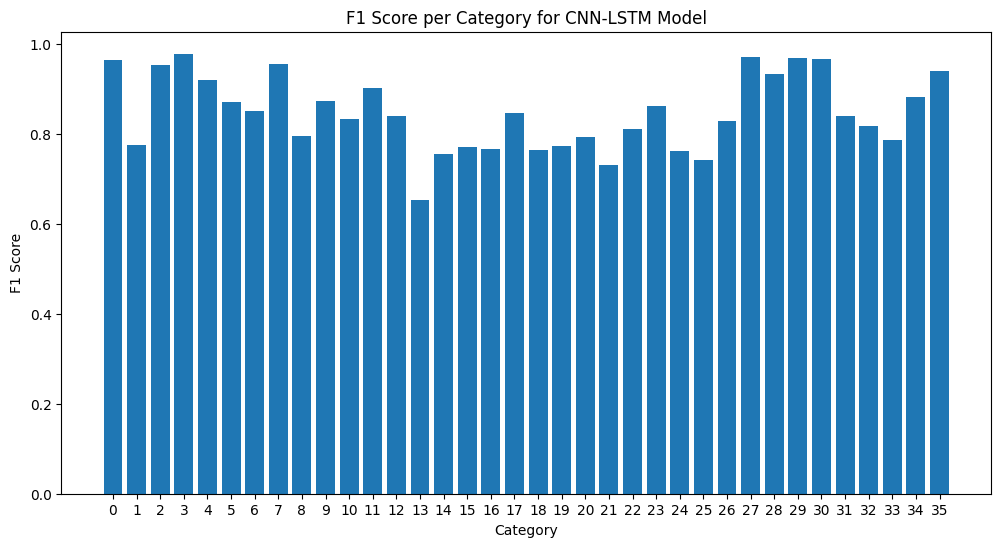

In [ ]:
embedding_dim = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(len(dataset['category'].unique()), activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(X_train_pad, y_train, epochs=10, batch_size=64)


loss, accuracy = model.evaluate(X_test_pad, y_test)
print('Test accuracy:', accuracy)


y_pred_prob = model.predict(X_test_pad)
y_pred = y_pred_prob.argmax(axis=1)


print(classification_report(y_test, y_pred))


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")

# Calculate F1 score for each category
f1_scores_per_category = f1_score(y_test, y_pred, average=None)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores_per_category)), f1_scores_per_category)
plt.xlabel("Category")
plt.ylabel("F1 Score")
plt.title("F1 Score per Category for CNN-LSTM Model")
plt.xticks(range(len(f1_scores_per_category)))
plt.show()

# Predicción de nuevos datos utilizando el modelo entrenado LSTM + Similitud semántica

In [53]:
dataset_excluded = dataset[~dataset['topic1'].isin(dataset_final['topic1'])]
dataset_excluded = dataset_excluded[["topic1", "question"]]
label_encoder = LabelEncoder()
dataset_excluded['category'] = label_encoder.fit_transform(dataset_excluded['topic1'])


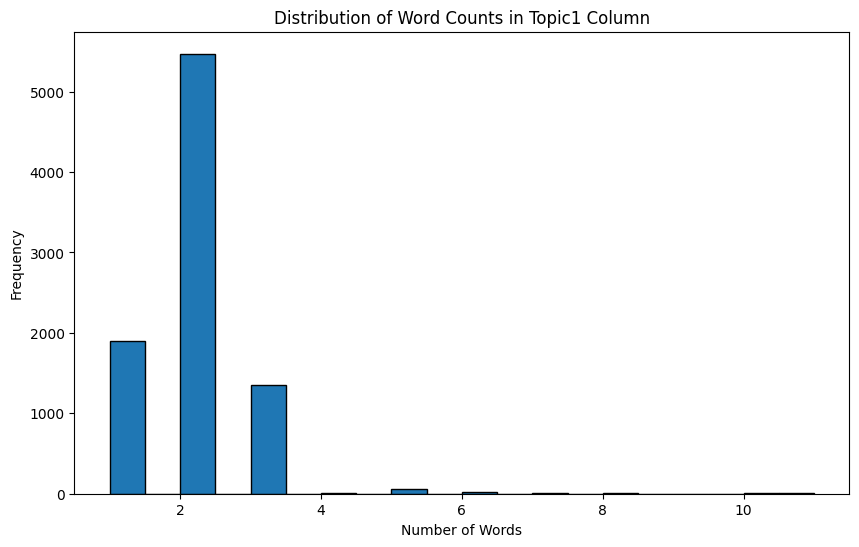

In [65]:

word_counts = dataset_excluded['topic1'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=20, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Topic1 Column')
plt.show()


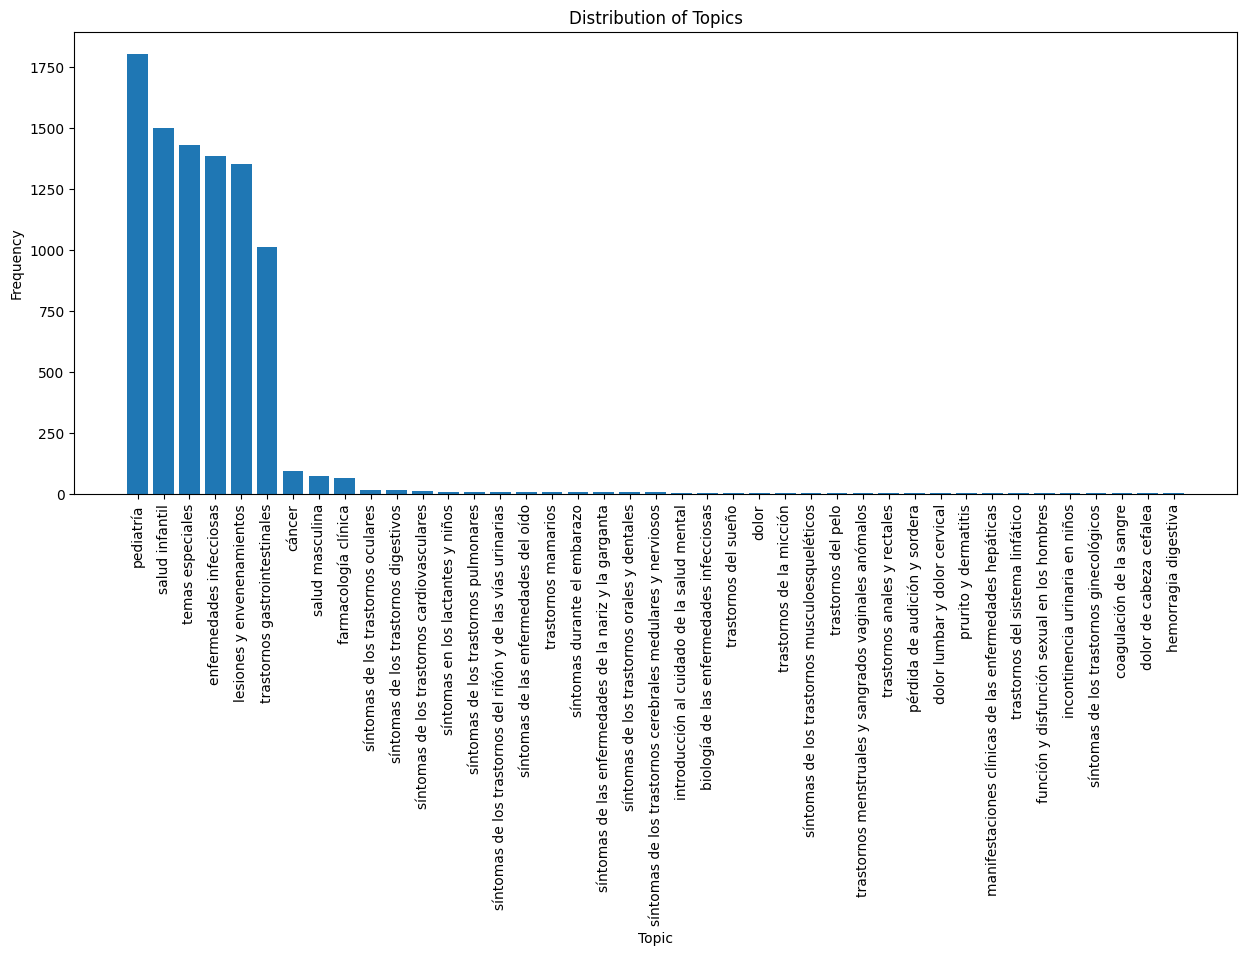

In [62]:

topic_counts = dataset_excluded['topic1'].value_counts()

plt.figure(figsize=(15, 6))
plt.bar(topic_counts.index, topic_counts.values)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Distribution of Topics')
plt.xticks(rotation=90)
plt.show()


In [54]:
X_excluded = dataset_excluded["question"]
y_excluded = dataset_excluded['category']

X_excluded_seq = tokenizer.texts_to_sequences(X_excluded)
X_excluded_pad = pad_sequences(X_excluded_seq, maxlen=max_sequence_length)

y_pred_excluded_prob = model_lstm.predict(X_excluded_pad)
y_pred_excluded = y_pred_excluded_prob.argmax(axis=1)

print(classification_report(y_excluded, y_pred_excluded))


277/277 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        94
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.03      0.00      0.01      1386
           7       0.00      0.00      0.00        64
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3
          12       0.10      0.01      0.02      1351
          13       0.00      0.00      0.00         2
          14       0.10      0.02      0.03      1806
          15       0.00      0.00      0.00         2
          16       0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [55]:
dataset_excluded['predicted_category'] = y_pred_excluded
category_to_topic1 = dict(zip(unique_topics_df['category'], unique_topics_df['topic1']))
dataset_excluded['predicted_topic1'] = dataset_excluded['predicted_category'].map(category_to_topic1)
dataset_excluded

,topic1,question,category,predicted_category,predicted_topic1
4,pediatría,cómo trata ansiedad separación niños,14,31,trastornos psiquiátricos
7,salud infantil,cómo identifican síntomas atresia biliar niño,17,19,trastornos del hígado y de la vesícula biliar
44,pediatría,cómo cateteriza vejiga niña cuidados posterior...,14,34,trastornos urogenitales
46,enfermedades infecciosas,dame información toxoplasmosis,6,7,infecciones
77,salud infantil,qué conceptos clave incontinencia urinaria niñ...,17,34,trastornos urogenitales
...,...,...,...,...,...
26585,temas especiales,puedes darme información problemas después viaje,32,10,salud femenina
26594,enfermedades infecciosas,cómo presenta vacuna hepatitis hepa saber enfe...,6,7,infecciones
26600,lesiones y envenenamientos,cómo presentan lesiones envenenamiento qué des...,12,35,traumatismos y envenenamientos
26605,salud infantil,cómo manejan complicaciones artritis idiopátic...,17,26,trastornos neurológicos


In [56]:
vectorizer = CountVectorizer()
topic1_vectors = vectorizer.fit_transform(dataset_excluded['topic1'].astype(str))
predicted_topic1_vectors = vectorizer.transform(dataset_excluded['predicted_topic1'].astype(str))

cosine_similarities = cosine_similarity(topic1_vectors, predicted_topic1_vectors)
dataset_excluded['cosine_similarity'] = np.diag(cosine_similarities)

In [57]:
dataset_excluded['cosine_similarity'].describe()

,cosine_similarity
count,8843.000000
mean,0.172344
std,0.291578
min,0.000000
25%,0.000000
50%,0.000000
75%,0.316228
max,0.774597


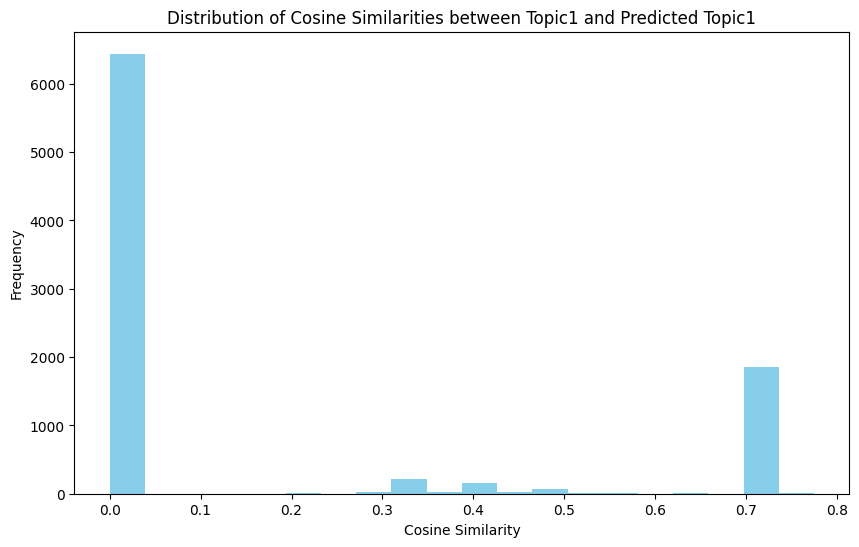

In [58]:

plt.figure(figsize=(10, 6))
plt.hist(dataset_excluded['cosine_similarity'], bins=20, color='skyblue')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities between Topic1 and Predicted Topic1')
plt.show()


In [59]:

dataset_excluded_sorted = dataset_excluded.sort_values('cosine_similarity', ascending=False)
print(dataset_excluded_sorted[['topic1', 'predicted_topic1', 'cosine_similarity']].head(10))


                                               topic1  \
30334           síntomas de los trastornos digestivos   
27142           síntomas de los trastornos digestivos   
51325  síntomas de los trastornos musculoesqueléticos   
28146  síntomas de los trastornos musculoesqueléticos   
2737                         coagulación de la sangre   
13490                   trastornos gastrointestinales   
13325                                  salud infantil   
13230                      lesiones y envenenamientos   
16267                   trastornos gastrointestinales   
36000                   trastornos gastrointestinales   

                                        predicted_topic1  cosine_similarity  
30334  trastornos de los huesos, articulaciones y mús...           0.774597  
27142  trastornos de los huesos, articulaciones y mús...           0.774597  
51325  trastornos de los huesos, articulaciones y mús...           0.774597  
28146  trastornos de los huesos, articulaciones y mús...    

In [60]:
dataset_excluded_sorted

,topic1,question,category,predicted_category,predicted_topic1,cosine_similarity
30334,síntomas de los trastornos digestivos,cómo identifican trastornos gastrointestinales...,24,16,"trastornos de los huesos, articulaciones y mús...",0.774597
27142,síntomas de los trastornos digestivos,cómo identifican trastornos gastrointestinales...,24,16,"trastornos de los huesos, articulaciones y mús...",0.774597
51325,síntomas de los trastornos musculoesqueléticos,qué síntomas trastornos musculoesqueléticos tr...,26,16,"trastornos de los huesos, articulaciones y mús...",0.774597
28146,síntomas de los trastornos musculoesqueléticos,qué síntomas trastornos musculoesqueléticos tr...,26,16,"trastornos de los huesos, articulaciones y mús...",0.774597
2737,coagulación de la sangre,cómo manejan hematomas sangrado relacionados t...,1,15,trastornos de la sangre,0.750000
...,...,...,...,...,...,...
38217,pediatría,cómo trata tronco arterioso persistente pediatría,14,33,trastornos renales y del tracto urinario,0.000000
38208,salud infantil,cómo trata luxación rodilla niños,17,35,traumatismos y envenenamientos,0.000000
38193,enfermedades infecciosas,cómo diagnostica tuberculosis ósea articular,6,7,infecciones,0.000000
38166,enfermedades infecciosas,qué entiende enfermedades infecciosas arboviru...,6,7,infecciones,0.000000


In [61]:

dataset_excluded_sorted.to_csv('dataset_excluded_sorted.csv', index=False)
